# Feedforward Neural Networks (pt. 2) #
<img align="left" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/300px-Colored_neural_network.svg.png" />

In the previous section, we built a softmax classifier with the objective function: $$J = minimize\{-log(\hat{y}_{correct})\}$$

Where $\hat{y}_{correct} \in \hat{y}$ and $\hat{y} = softmax(x~W)$

So far, the forward pipeline is as follows:

1. Multiply your input $x$ by the matrix $W$ to obtain the scores (call them $s$) for each class.
2. Compute $softmax(s)$ to obtain $\hat{y}$ (the "probabilities" for each class).
3. Compute the cross entropy objective (commonly known as the "cross entropy loss")

The backward pipeline, applied to train the classifier using gradient descent, is as follows:

1. Compute the gradient of the objective function w.r.t. the "trainable" parameters stored in $W$.
2. Update the parameters using the gradients computed.

We can easily transform this into a Neural Network by adding a "hidden layer" between the input $x$ and the step where we compute the scores. Everything else would remain the same.

The forward pipeline would now look as follows:

1. Multiply your input $x$ by the matrix $W^{(h)} \in \mathbf{R^{DxH}}$ (where $(h)$ is only an identifier for the matrix, and $\mathbf{H}$ is the number of columns) to obtain the hidden state $h \in \mathbf{R^{1xH}}$.
1. Multiply your hidden state $h$ by the output matrix $W^{(o)} \in \mathbf{R^{HxC}}$ (where $(o)$ is only an identifier for the matrix) to obtain the scores $s$ for each class.
2. Compute $softmax(s)$ to obtain $\hat{y}$ (the "probabilities" for each class).
3. Compute the cross entropy objective (commonly known as the "cross entropy loss")

So the objective looks exacty the same, but $\hat{y}$ now is:
$\hat{y} = softmax(x~W^{(h)}~W^{(o)})$

The backward pipeline, applied to train the classifier using gradient descent, is as follows:

1. Compute the gradient of the objective function w.r.t. the "trainable" parameters in $W^{(h)}$ and $W^{(o)}$.
2. Update the parameters using the gradients computed.

As you can see, now we will have to compute two gradients:

$\frac{\partial J}{\partial W^{(h)}}$

$\frac{\partial J}{\partial W^{(o)}}$

These gradients would be similar to the ones we calculated previously (note that the scores $s$ now are $s=~x ~W^{(h)} ~W^{(o)}$):

$\frac{\partial J }{\partial W^{(h)}} = ~\big(\frac{\partial ~x ~W^{(h)} ~W^{(o)}}{\partial W^{(h)}}\big)^T~\frac{\partial J}{\partial \hat{y}} ~\frac{\partial \hat{y}}{\partial ~x ~W^{(h)} ~W^{(o)}} = ~\big(\frac{\partial ~x ~W^{(h)} ~W^{(o)}}{\partial W^{(h)}}\big)^T~\frac{\partial J}{\partial s} = \big(x^T~\frac{\partial J}{\partial s}\big) ~\big(W^{(o)}\big)^T$

$\frac{\partial J }{\partial W^{(o)}} = ~\big(\frac{\partial ~x ~W^{(h)} ~W^{(o)}}{\partial W^{(o)}}\big)^T~\frac{\partial J}{\partial \hat{y}} ~\frac{\partial \hat{y}}{\partial ~x ~W^{(h)} ~W^{(o)}} = ~\big(\frac{\partial ~x ~W^{(h)} ~W^{(o)}}{\partial W^{(o)}}\big)^T ~\frac{\partial J}{\partial s} = \bigg(~\big(W^{(h)}\big)^T~x^T\bigg)~\frac{\partial J}{\partial s}$

And an update step in the direction that maximizes the value of the objective function would be:

$W^{(o)} := ~W^{(o)} + ~\alpha~\frac{\partial J }{\partial W^{(o)}}$

$W^{(h)} := ~W^{(h)} + ~\alpha~\frac{\partial J }{\partial W^{(h)}}$

Where $\alpha$ is a tunable free parameter better known as the "learning rate"

Modify your previous program so that this time we have a Neural Network with a hidden layer (you'll first have to reuse code that generates "fake" data)

Experiment with changing the $\alpha$ parameter. What else could you experiment with? (i.e. what are your "tunable" hyperparameters?)

In [1]:
# generate and organize fake data

# data parameters
N = 20
D = 5
C = 3

# setting a seed to be able to compare results
srand(0)

# synthetic data
all_data = rand(N, D)
all_labels = rand(1:C,N,1)
data = [all_data all_labels];

perc_tr = 0.8
perc_vl = 0.1
perc_ts = 0.1

# randomly shuffle the data
data = data[shuffle(1:size(data)[1]), :]

# separate into training, validation, and test sets
# data
x_tr = data[1:floor(Int,N*perc_tr),1:end-1]
x_vl = data[floor(Int,N*perc_tr)+1:floor(Int,N*perc_tr)+floor(Int,N*perc_vl),1:end-1]
x_ts = data[floor(Int,N*perc_tr)+floor(Int,N*perc_vl)+1:end,1:end-1]
# labels
y_tr = reshape(data[1:floor(Int,N*perc_tr),end],size(x_tr)[1],1)
y_vl = reshape(data[floor(Int,N*perc_tr)+1:floor(Int,N*perc_tr)+floor(Int,N*perc_vl),end],size(x_vl)[1],1)
y_ts = reshape(data[floor(Int,N*perc_tr)+floor(Int,N*perc_vl)+1:end,end],size(x_ts)[1],1);

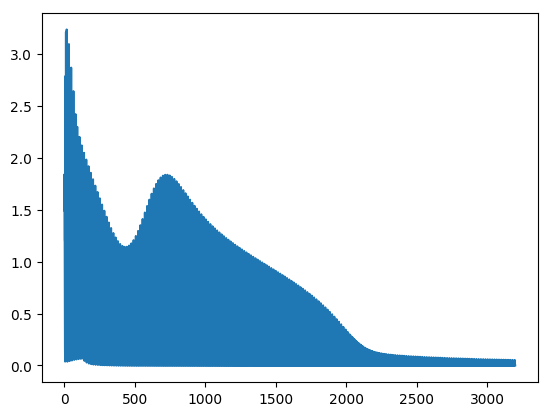

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9a3950a450>

In [2]:
# hyperparameter alpha
a = 0.1
# the number of hidden layers
H = 10

# the W matrix
W_h = (rand(D,H));
W_o = (rand(H,C));
nepochs = 200
J = zeros(nepochs*size(x_tr)[1],1)
for ep=0:nepochs-1

    for t=1:size(x_tr)[1]

        # forward pass
        h = *(reshape(x_tr[t,:],1,D),W_h)
        scores = *(h,W_o)
        probs = exp(scores)./sum(exp(scores))

        # objective 
        J[floor(Int,ep*size(x_tr)[1] + t),1] = -log(probs[1,floor(Int,y_tr[t])])

        # backward pass
        dJ_dscores = probs
        dJ_dscores[1,floor(Int,y_tr[t])] -= 1

        dJ_dW_h = *(*(reshape(x_tr[t,:],1,D)',dJ_dscores),W_o')
        dJ_dW_o = *(*(W_h',reshape(x_tr[t,:],1,D)'),dJ_dscores)        

        W_h -= a*dJ_dW_h;
        W_o -= a*dJ_dW_o;        

    end
end
using PyPlot
plot(J)

What did you notice? What effect did tuning of hyperparameters have?

What makes this a good/bad/better/worse way to make a Neural Network Learn? How can we make it better?

Highlight observation with a group of classmates and be prepared to share with the class. 

The next logical step would be to add a non-linear function $f()$ right before reaching the hidden layer. This is in fact very common practice. The model would then compute $\hat{y}$ like this:

$$\hat{y} = softmax( ~f(x~W^{(h)})~W^{(o)})$$

There is a whole collection of different non-linearities that you can use. In fact, people have gotten graduate degrees carrying research aimed at finding the best non-linearities that solve different problems.

In practice, common non-linearities are:

* $\sigma(\theta)$ (the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function))
* $\tanh(\theta)$ (the [hyperbolic tangent](http://reference.wolfram.com/language/ref/Tanh.html.en))
* $\text{ReLU}(\theta) = f(\theta)=\max(0,\theta)$ (the Rectified Linear Unit)

For the purposes of this notebook we will focus on the first two, but feel free to experiment with any non-linearities you would like to. 

You can imagine that other side of the coin when adding a non-linearity to a Neural Network is knowing its derivative. 

Thankfully, the derivatives for $\sigma(\theta)$ and $\tanh(\theta)$ w.r.t $\theta$ are relatively simple:

$$\frac{\partial \sigma(\theta)}{\partial \theta} = \sigma(\theta)(1-\sigma(\theta)) $$

$$\frac{\partial \tanh(\theta)}{\partial \theta} = 1-\tanh^2(\theta)$$

As a case study, let's assume that we pick the sigmoid $\sigma(\theta)$ non-linearity to obtain the following expression:

$$\hat{y} = softmax( ~\sigma(x~W^{(h)})~W^{(o)})$$

The derivative of the cost function w.r.t parameters $W^{(h)}$ and $W^{(o)}$ would be:

$\frac{\partial J }{\partial W^{(o)}} = ~\big(\frac{\partial \sigma(~x~W^{(h)})~W^{(o)}}{\partial W^{(o)}}\big)^T~\frac{\partial J}{\partial \hat{y}} ~\frac{\partial \hat{y}}{\partial ~x ~W^{(h)} ~W^{(o)}} = ~\sigma(~x~W^{(h)})^T~\frac{\partial J}{\partial s}$



$\frac{\partial J }{\partial W^{(h)}} = ~\big(\frac{\partial \sigma(~x~W^{(h)})~W^{(o)}}{\partial W^{(h)}}\big)^T~\frac{\partial J}{\partial \hat{y}} ~\frac{\partial \hat{y}}{\partial ~x ~W^{(h)} ~W^{(o)}} = ~\big(\frac{\partial \sigma(~x~W^{(h)})~W^{(o)}}{\partial W^{(h)}}\big)^T~\frac{\partial J}{\partial s} =
x^T\bigg(\big( \sigma(~x~W^{(h)})(1-\sigma(~x~W^{(h)})) \big) \circ \big(~\frac{\partial J}{\partial s} ~(W^{(o)})^T\big)\bigg)$

where $\circ$ indicates the element-wise multiplication of two arrays.

Modify your previous program so that this time we have a Neural Network with a hidden layer and non-linear sigmoid gating.

Julia doesn't have a sigmoid function, so you'll have to write your own.

Experiment tuning your hyperparameters. Also, have you tried changing the initialization of the $W^{(h)}$ and the $W^{(o)}$ matrices? Would that matter at all?

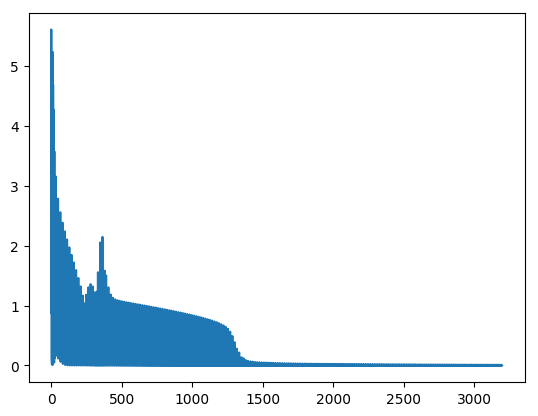

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fae7e6cbfd0>

In [15]:
# hyperparameter alpha
a = 1
# the number of hidden layers
H = 10

function sigmoid(theta)

  return 1.0 ./ (1.0 .+ exp(-theta))

end

# the W matrix
W_h = (rand(D,H));
W_o = (rand(H,C));
nepochs = 200
J = zeros(nepochs*size(x_tr)[1],1)
for ep=0:nepochs-1

    for t=1:size(x_tr)[1]

        # forward pass
        h = sigmoid(*(reshape(x_tr[t,:],1,D),W_h))
        scores = *(reshape(h,1,H),W_o)
        probs = exp(scores)./sum(exp(scores))

        # objective 
        J[floor(Int,ep*size(x_tr)[1] + t),1] = -log(probs[1,floor(Int,y_tr[t])])

        # backward pass
        dJ_dscores = probs
        dJ_dscores[1,floor(Int,y_tr[t])] -= 1

        dJ_dW_o = *(h',dJ_dscores)        
        dJ_dW_h = *(reshape(x_tr[t,:],1,D)',(reshape(h,1,H).*(1.-reshape(h,1,H))).*(*(dJ_dscores,W_o')))

        W_h -= a*dJ_dW_h;
        W_o -= a*dJ_dW_o;        

    end
end
using PyPlot
plot(J)

That's it! You have built a Neural Network from scratch.

Feel free to experiment with other non-linearities, adding more hidden layers (even with different non-linearities), and tuning your hyperparameters.

Congratulations!